# Dimensionality Reduction Evaluation
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate dimensionality reduction techniques for their ability to preserve Euclidean structure of high-dimensional datasets.__  
  
To benchmark these techniques, we are using two single-cell RNAseq datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse colon scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be __discrete__, containing highly separable cell populations from the mouse retina, where the latter will be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
Both datasets have been __preprocessed and feature-selected__ to allow for direct input to downstream dimensionality reduction algorithms (rather than first performing PCA to limit dimensional input). These methods are shown in [`dev/preprocess_and_filter.ipynb`](dev/preprocess_and_filter.ipynb).

In [20]:
from fcc_DRs import *
%matplotlib inline

In [2]:
# read in Macosko retina data
retina = RNA_counts.from_file('inputs/GSM1626793_P14Retina_1.processed.tsv', cells_axis=0, labels=[0,0])
# read in Herring colon data
colon = RNA_counts.from_file('inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', cells_axis=0, labels=[0,0])

In [3]:
# look at dimensions of counts matrix (cells, genes)
retina.data.shape

(1603, 500)

In [4]:
# look at dimensions of counts matrix (cells, genes)
colon.data.shape

(1738, 500)

---
### PCA
We'll look at principal component analysis (PCA) first, as a gold-standard. Because PCA performs a __linear__ transformation on the data, 500 PCs should perfectly preserve the overall dataset structure.

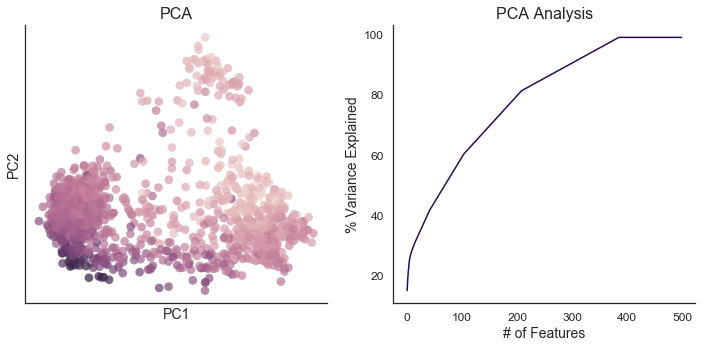

In [22]:
retina_PCA500 = fcc_PCA(retina.arcsinh_norm(), n_components=500)
retina_PCA500.plot_PCA()

We can test the Euclidean distance preservation as follows:

In [23]:
# choose value for K-nearest neighbor calculations. We use 30 because that is the standard perplexity chosen for DR techniques here.
k = 30

In [ ]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input to PCA.
mantel, EMD, KLD = compare_euclid(pre=retina.distance_matrix(transform='arcsinh'), post=retina_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_PCA500.knn_graph(k))))

Now we can perform a PCA with a smaller number of components and determine the degree of information loss.  
The extreme example would be comparing only the __first two principal components__ to the original dataset:

In [ ]:
retina_PCA2 = fcc_PCA(retina.arcsinh_norm(), n_components=2)
retina_PCA2.plot_PCA()

In [ ]:
%%time
# look at 2-component PCA vs 500-feature dataset.
# transform==arcsinh for distance matrix here bc that's the input to PCA.
mantel, EMD, KLD = compare_euclid(pre=retina.distance_matrix(transform='arcsinh'), post=retina_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_PCA2.knn_graph(k))))

In [ ]:
colon_PCA2 = fcc_PCA(colon.arcsinh_norm(), n_components=2)
colon_PCA2.plot_PCA()

In [ ]:
%%time
# look at 2-component PCA vs 500-feature dataset.
# transform==arcsinh for distance matrix here bc that's the input to PCA.
mantel, EMD, KLD = compare_euclid(pre=colon.distance_matrix(transform='arcsinh'), post=colon_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_PCA2.knn_graph(k))))

---
# t-SNE
A workhorse technique for dimensionality reduction and visualization of scRNA-seq datasets, t-SNE performs a stochastic, non-linear transformation to project high-dimensional data into 2D in order to identify clustering and global structure.  
Here, we will plug arcsinh-normalized counts data directly into t-SNE and compare results to the original, feature-selected dataset.

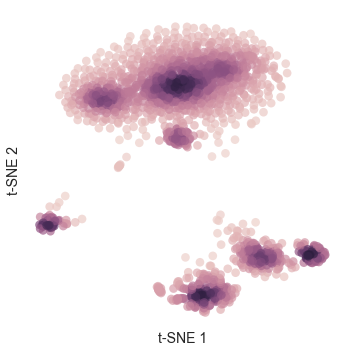

In [18]:
retina_tSNE = fcc_tSNE(retina.arcsinh_norm(), perplexity=50, seed=18)
retina_tSNE.plot()

In [12]:
np.where(retina_tSNE.results == np.min(retina_tSNE.results))

(array([356]), array([0]))

In [16]:
retina.data.drop(axis=0, index=retina.data.index[356], inplace=True)
retina.data.shape

(1602, 500)

In [17]:
retina = RNA_counts(data=retina.data)

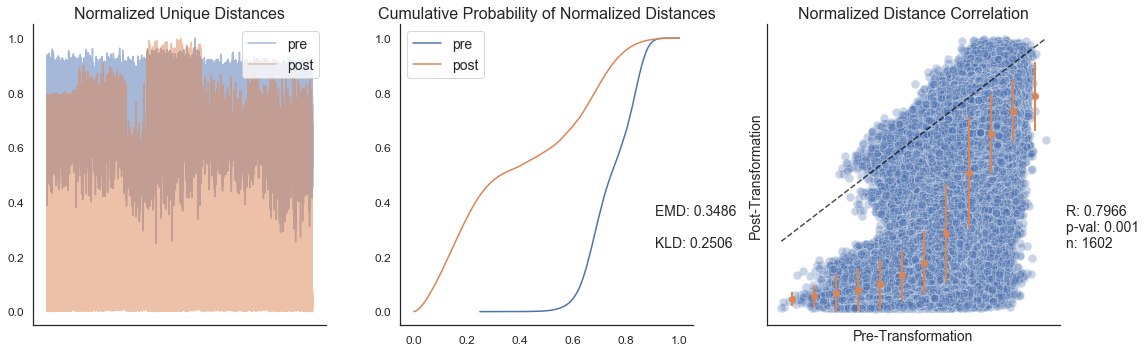

Knn Preservation: 97.132

CPU times: user 1min 24s, sys: 9.81 s, total: 1min 34s
Wall time: 1min 34s


In [19]:
%%time
# look at t-SNE vs 500-feature dataset.
# transform==arcsinh for distance matrix here bc that's the input to t-SNE.
mantel, EMD, KLD = compare_euclid(pre=retina.distance_matrix(transform='arcsinh'), post=retina_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_tSNE.knn_graph(k))))

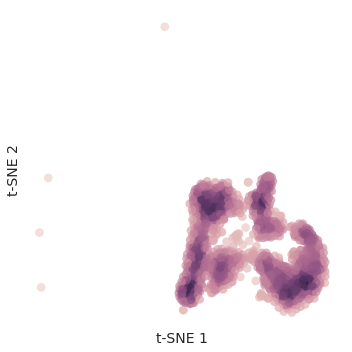

In [23]:
colon_tSNE = fcc_tSNE(colon.arcsinh_norm(), perplexity=30, seed=12)
colon_tSNE.plot()

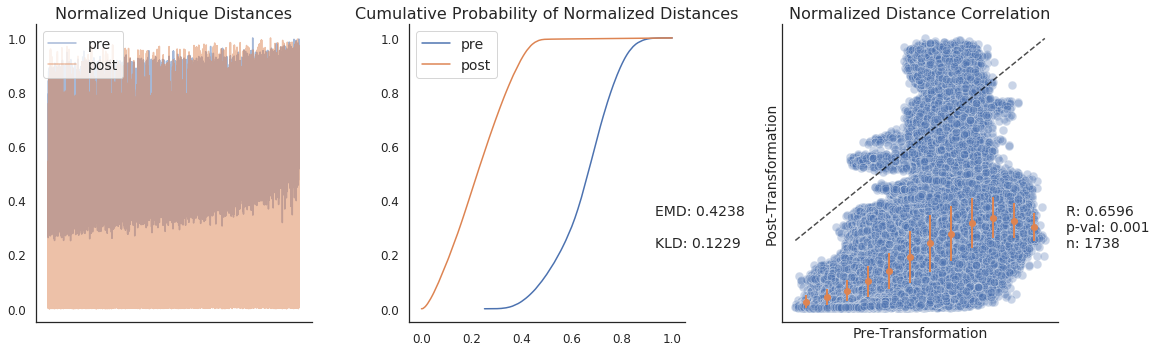

Knn Preservation: 97.8121

CPU times: user 1min 50s, sys: 892 ms, total: 1min 51s
Wall time: 1min 50s


In [24]:
%%time
# look at t-SNE vs 500-feature dataset.
# transform==arcsinh for distance matrix here bc that's the input to t-SNE.
mantel, EMD, KLD = compare_euclid(pre=colon.distance_matrix(transform='arcsinh'), post=colon_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_tSNE.knn_graph(k))))

---
# UMAP
Another popular method for low-dimensional projection of scRNA-seq datasets, UMAP creates high-dimensional manifolds that describe the structure of the dataset.  
Here, we will plug arcsinh-normalized counts data directly into UMAP and compare results to the original, feature-selected dataset.

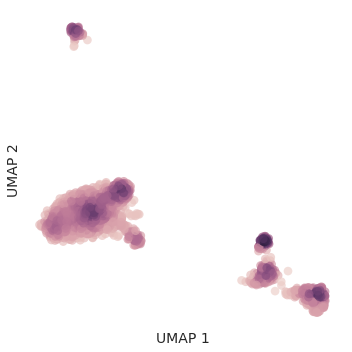

In [25]:
retina_UMAP = fcc_UMAP(retina.arcsinh_norm(), perplexity=30, seed=12)
retina_UMAP.plot()

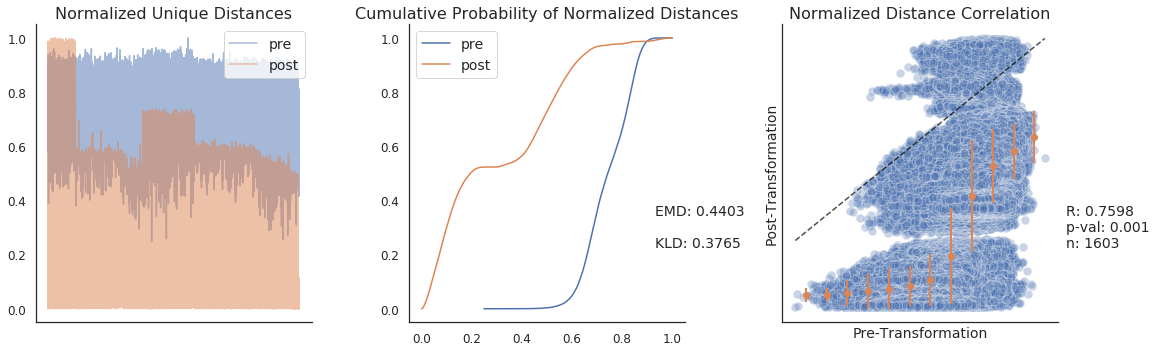

Knn Preservation: 96.8706

CPU times: user 1min 39s, sys: 855 ms, total: 1min 39s
Wall time: 1min 38s


In [26]:
%%time
# look at UMAP vs 500-feature dataset.
# transform==arcsinh for distance matrix here bc that's the input to UMAP.
mantel, EMD, KLD = compare_euclid(pre=retina.distance_matrix(transform='arcsinh'), post=retina_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_UMAP.knn_graph(k))))

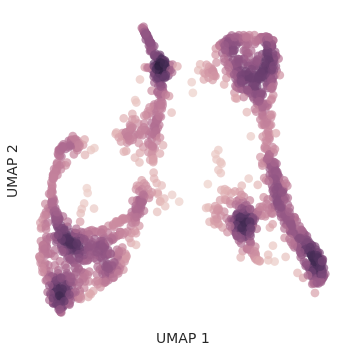

In [27]:
colon_UMAP = fcc_UMAP(colon.arcsinh_norm(), perplexity=30, seed=12)
colon_UMAP.plot()

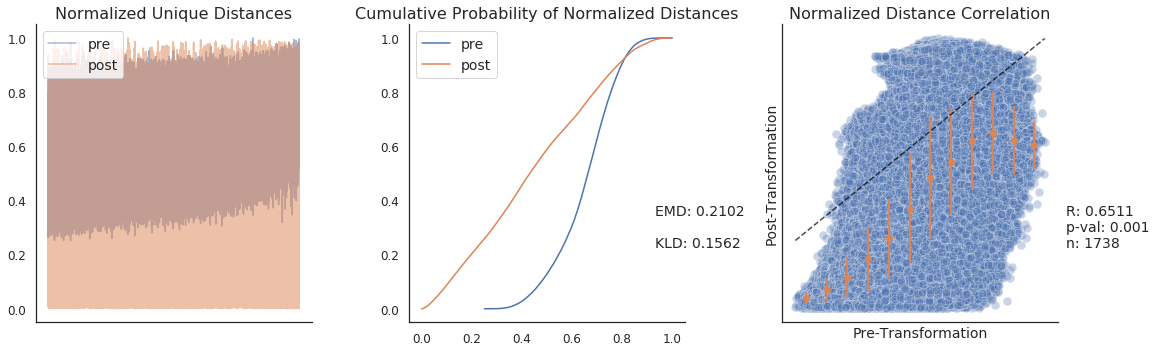

Knn Preservation: 97.7475

CPU times: user 1min 55s, sys: 883 ms, total: 1min 56s
Wall time: 1min 55s


In [28]:
%%time
# look at UMAP vs 500-feature dataset.
# transform==arcsinh for distance matrix here bc that's the input to UMAP.
mantel, EMD, KLD = compare_euclid(pre=colon.distance_matrix(transform='arcsinh'), post=colon_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_UMAP.knn_graph(k))))

---
# ZIFA
This method uses the zero-inflated negative binomial distribution to reduce RNA counts data to lower dimensions.  
Here, we will plug arcsinh-normalized counts data directly into ZIFA and compare results to the original, feature-selected dataset.

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1603, D = 481, K = 2, n_blocks = 1
Block sizes [481]
Param change below threshold 1.000e-02 after 12 iterations


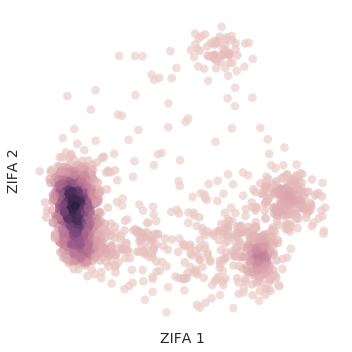

In [29]:
retina_ZIFA = fcc_ZIFA(retina.arcsinh_norm(), K=2)
retina_ZIFA.plot()

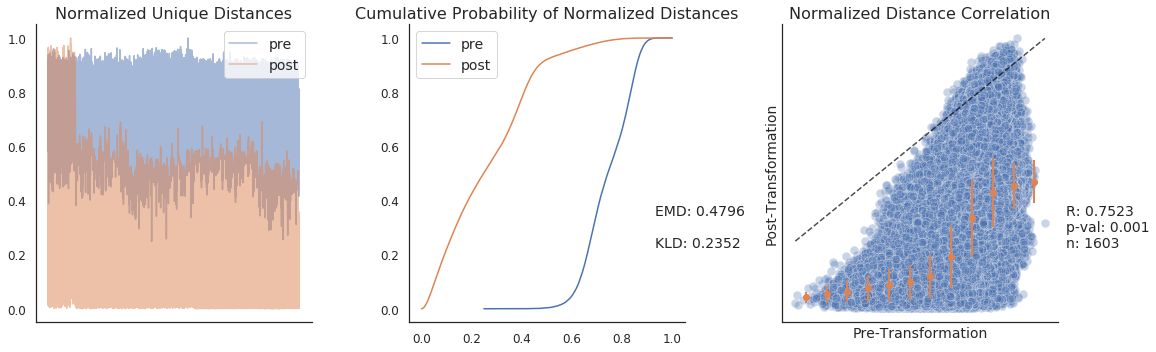

Knn Preservation: 96.9614

CPU times: user 1min 38s, sys: 1.01 s, total: 1min 39s
Wall time: 1min 38s


In [30]:
%%time
# look at ZIFA vs 500-feature dataset.
# transform==arcsinh for distance matrix here bc that's the input to ZIFA.
mantel, EMD, KLD = compare_euclid(pre=retina.distance_matrix(transform='arcsinh'), post=retina_ZIFA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_ZIFA.knn_graph(k))))

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1738, D = 492, K = 2, n_blocks = 1
Block sizes [492]
Param change below threshold 1.000e-02 after 7 iterations


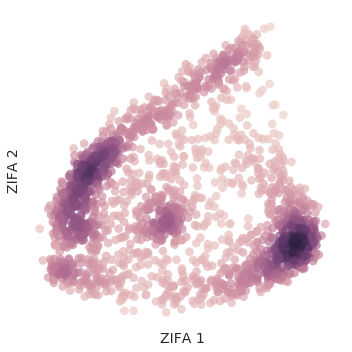

In [33]:
colon_ZIFA = fcc_ZIFA(colon.arcsinh_norm(), K=2)
colon_ZIFA.plot()

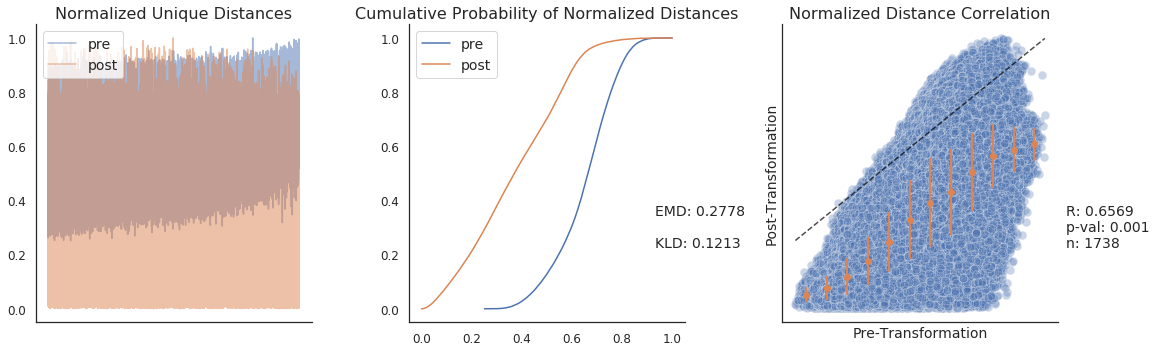

Knn Preservation: 97.6834

CPU times: user 1min 53s, sys: 11.9 s, total: 2min 5s
Wall time: 2min 4s


In [34]:
%%time
# look at ZIFA vs 500-feature dataset.
# transform==arcsinh for distance matrix here bc that's the input to ZIFA.
mantel, EMD, KLD = compare_euclid(pre=colon.distance_matrix(transform='arcsinh'), post=colon_ZIFA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_ZIFA.knn_graph(k))))

---
# DCA
This method uses a deep count autoencoder to reduce RNA counts data to lower dimensions.  
Here, we will plug counts data directly into DCA and compare results to the original, feature-selected dataset.

In [35]:
%time retina_DCA = fcc_DCA(retina.counts, n_threads=4, norm=False)

DCA: Successfully preprocessed 500 genes and 1603 cells.
Instructions for updating:
Colocations handled automatically by placer.


2019-05-09 17:53:51,773 [WARNING] From /home/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


2019-05-09 17:53:52,425 [WARNING] From /home/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 22.7 s, sys: 1.11 s, total: 23.8 s
Wall time: 8.57 s


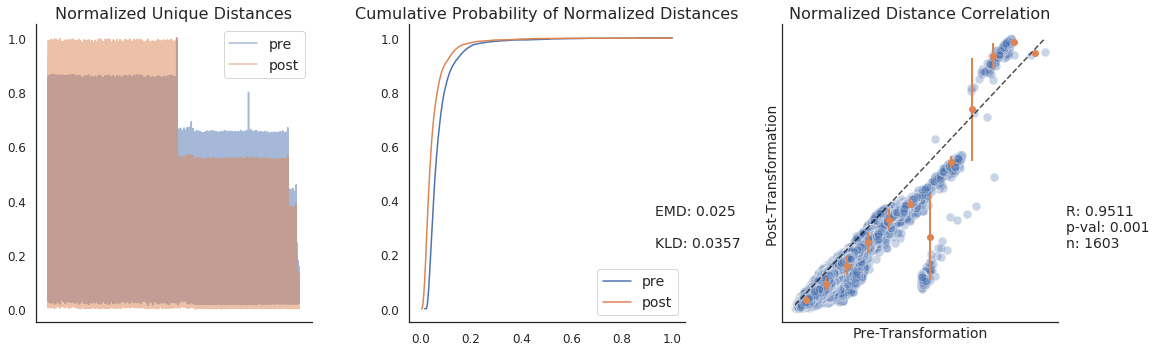

Knn Preservation: 97.5185

CPU times: user 1min 38s, sys: 884 ms, total: 1min 39s
Wall time: 1min 38s


In [38]:
%%time
# look at DCA vs 500-feature dataset.
# transform==None for distance matrix here bc that's the input to DCA.
mantel, EMD, KLD = compare_euclid(pre=retina.distance_matrix(transform=None), post=retina_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_DCA.knn_graph(k))))

In [39]:
%time colon_DCA = fcc_DCA(colon.counts, n_threads=4, norm=False)

DCA: Successfully preprocessed 500 genes and 1738 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 44.6 s, sys: 2.08 s, total: 46.7 s
Wall time: 15.1 s


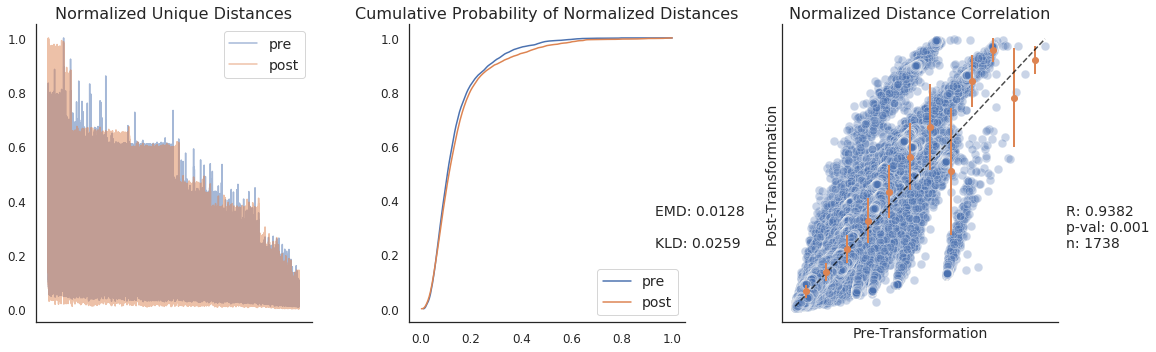

Knn Preservation: 98.304

CPU times: user 1min 57s, sys: 823 ms, total: 1min 58s
Wall time: 1min 56s


In [40]:
%%time
# look at DCA vs 500-feature dataset.
# transform==None for distance matrix here bc that's the input to DCA.
mantel, EMD, KLD = compare_euclid(pre=colon.distance_matrix(transform=None), post=colon_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_DCA.knn_graph(k))))

---
# sc-VI
Here, we will plug counts data directly into sc-VI and compare results to the original, feature-selected dataset.

In [42]:
from scvi.dataset import CsvDataset, GeneExpressionDataset
import urllib
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
use_batches=False

In [45]:
# Loading a local dataset into scVI
retina_scVI = CsvDataset('GSM1626793_P14Retina_1.processed.tsv', save_path='inputs/', new_n_genes=500, gene_by_cell=False, sep='\t')

File inputs/GSM1626793_P14Retina_1.processed.tsv already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [46]:
vae = VAE(retina_scVI.nb_genes, n_batch=retina_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              retina_scVI,
                              train_size=0.75,
                              use_cuda=True,
                              frequency=5)
trainer.train(n_epochs=400, lr=1e-3)

training: 100%|██████████| 400/400 [02:06<00:00,  2.86it/s]


In [47]:
full = trainer.create_posterior(trainer.model, retina_scVI, indices=np.arange(len(retina_scVI)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

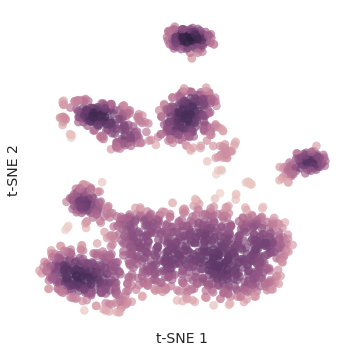

In [52]:
retina_scVI_tSNE = fcc_tSNE(matrix=latent, perplexity=30, seed=18)
retina_scVI_tSNE.plot()

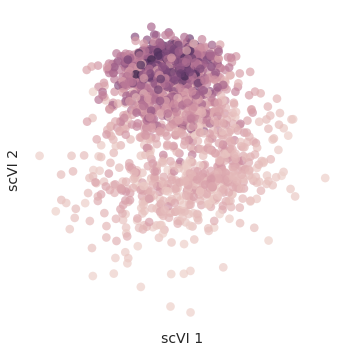

In [56]:
retina_scVI = DR(latent=latent, name='scVI')
retina_scVI.plot()

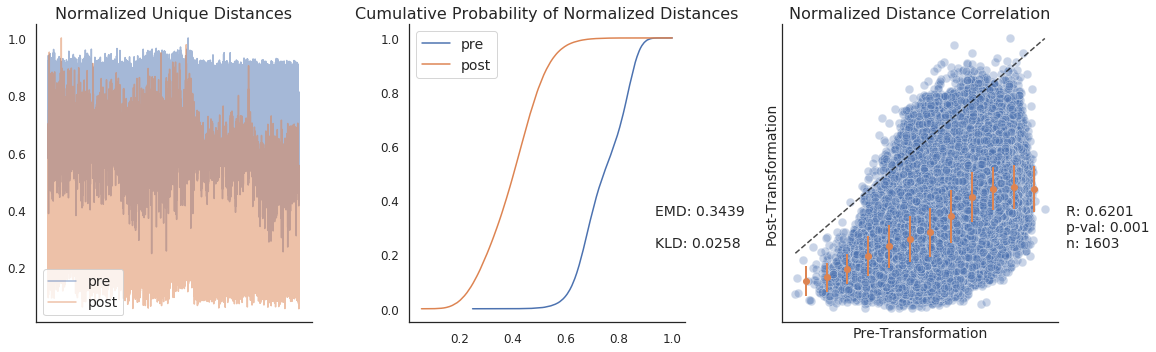

Knn Preservation: 96.9784

CPU times: user 1min 38s, sys: 807 ms, total: 1min 38s
Wall time: 1min 37s


In [57]:
%%time
# look at sc-VI vs 500-feature dataset.
# transform==arcsinh for distance matrix here bc that's the input to sc-VI.
mantel, EMD, KLD = compare_euclid(pre=retina.distance_matrix(transform='arcsinh'), post=retina_scVI.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_scVI.knn_graph(k))))

In [58]:
# Loading a local dataset into scVI
colon_scVI = CsvDataset('GSM2743164_rep1_colon_rnaseq.processed.tsv', save_path='inputs/', new_n_genes=500, gene_by_cell=False, sep='\t')

File inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [59]:
vae = VAE(colon_scVI.nb_genes, n_batch=colon_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              colon_scVI,
                              train_size=0.75,
                              use_cuda=True,
                              frequency=5)
trainer.train(n_epochs=400, lr=1e-3)

training: 100%|██████████| 400/400 [02:00<00:00,  3.03it/s]


In [61]:
full = trainer.create_posterior(trainer.model, colon_scVI, indices=np.arange(len(colon_scVI)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

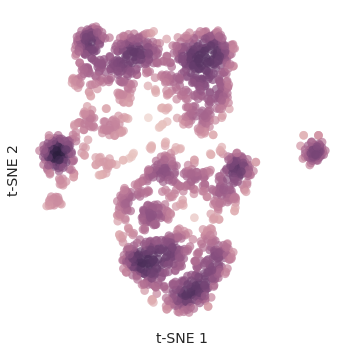

In [62]:
colon_scVI_tSNE = fcc_tSNE(matrix=latent, perplexity=30, seed=18)
colon_scVI_tSNE.plot()

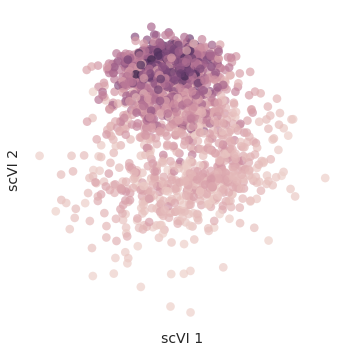

In [56]:
colon_scVI = DR(latent=latent, name='scVI')
colon_scVI.plot()

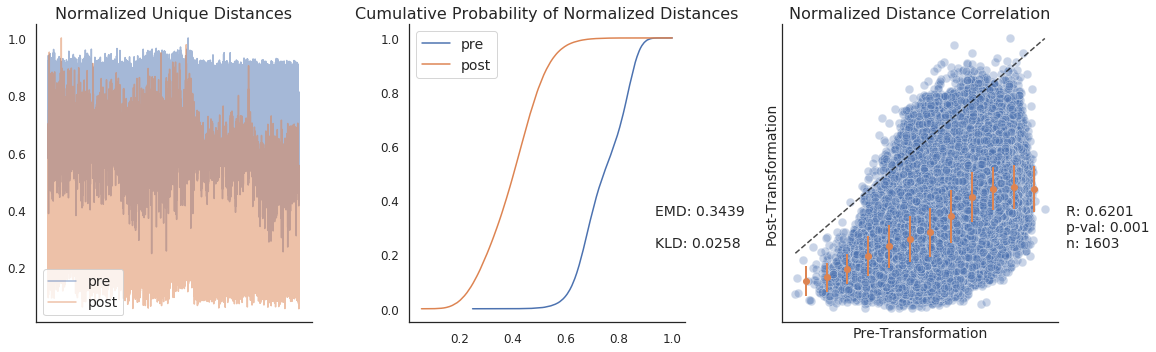

Knn Preservation: 96.9784

CPU times: user 1min 38s, sys: 807 ms, total: 1min 38s
Wall time: 1min 37s


In [57]:
%%time
# look at sc-VI vs 500-feature dataset.
# transform==arcsinh for distance matrix here bc that's the input to sc-VI.
mantel, EMD, KLD = compare_euclid(pre=colon.distance_matrix(transform='arcsinh'), post=colon_scVI.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_scVI.knn_graph(k))))

---
# scvis
Here, we will plug counts data directly into scvis and compare results to the original, feature-selected dataset.

In [5]:
retina_scvis = DR.from_file(datafile='dev/scvis_out/retina/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv',
                            name='scvis')

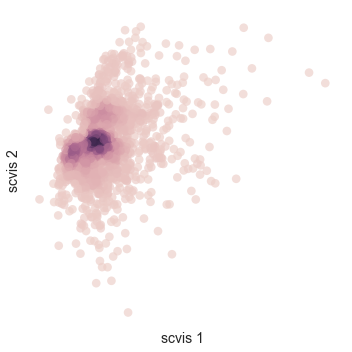

In [6]:
retina_scvis.plot()

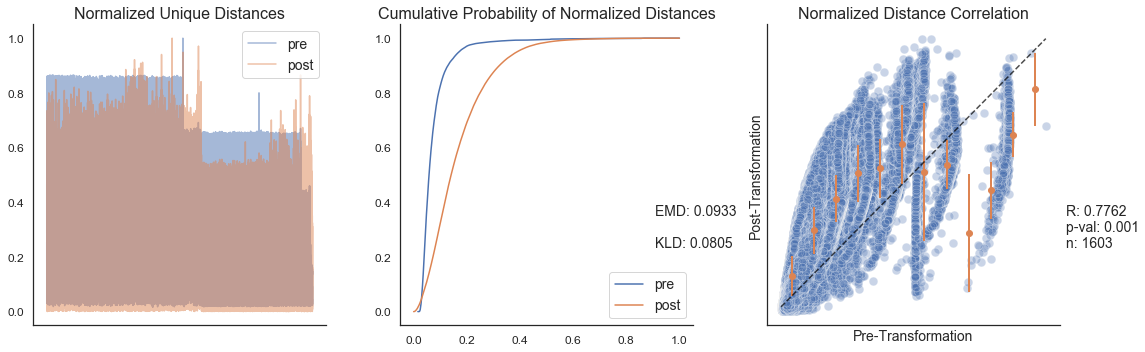

Knn Preservation: 98.041

CPU times: user 1min 25s, sys: 9.24 s, total: 1min 34s
Wall time: 1min 34s


In [9]:
%%time
# look at scvis vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=retina.distance_matrix(transform=None), post=retina_scvis.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_scvis.knn_graph(k))))

In [10]:
colon_scvis = DR.from_file(datafile='dev/scvis_out/colon/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv',
                            name='scvis')

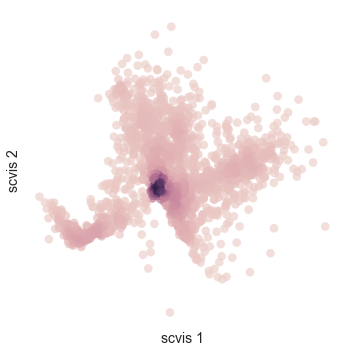

In [11]:
colon_scvis.plot()

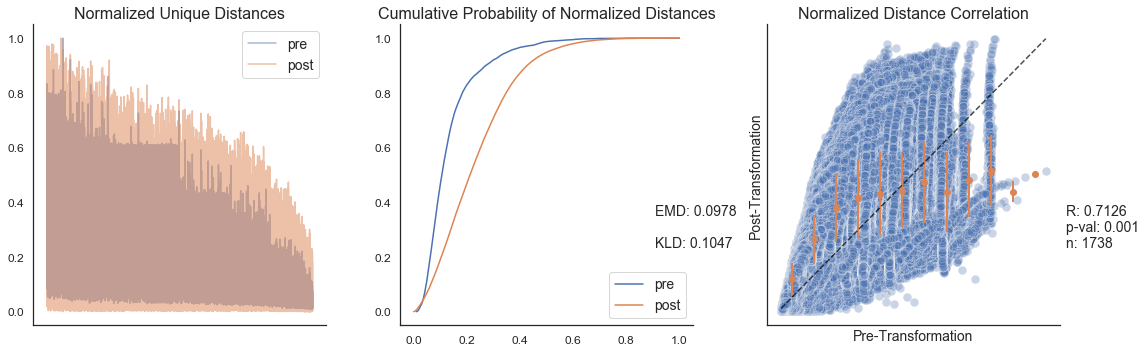

Knn Preservation: 98.3118

CPU times: user 1min 36s, sys: 12.8 s, total: 1min 49s
Wall time: 1min 49s


In [12]:
%%time
# look at scvis vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=colon.distance_matrix(transform=None), post=colon_scvis.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=colon.knn_graph(k, transform=None),  post=colon_scvis.knn_graph(k))))

---
# SIMLR
This method builds cell-cell similarity matrices to predict cluster number and assign cells to clusters based on similarity.
First, read in the `F` construct that consists of a c-dimensional output of length `n_cells`, where c is the number of expected clusters passed to SIMLR.  
Here, c was estimated using the `SIMLR_Estimate_Number_of_Clusters` function from the SIMLR package.

In [21]:
retina_SIMLR = DR.from_file('dev/Rmethods_out/retina_SIMLR_F.csv', name='SIMLR', labels=[None,0]) # read in low-dim space for comparison
retina_SIMLR_2D = DR.from_file('dev/Rmethods_out/retina_SIMLR_ydata.csv', name='SIMLR', labels=[None,0]) # read in 2D projection for visualization

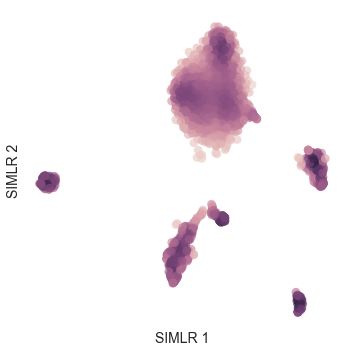

In [22]:
retina_SIMLR_2D.plot()

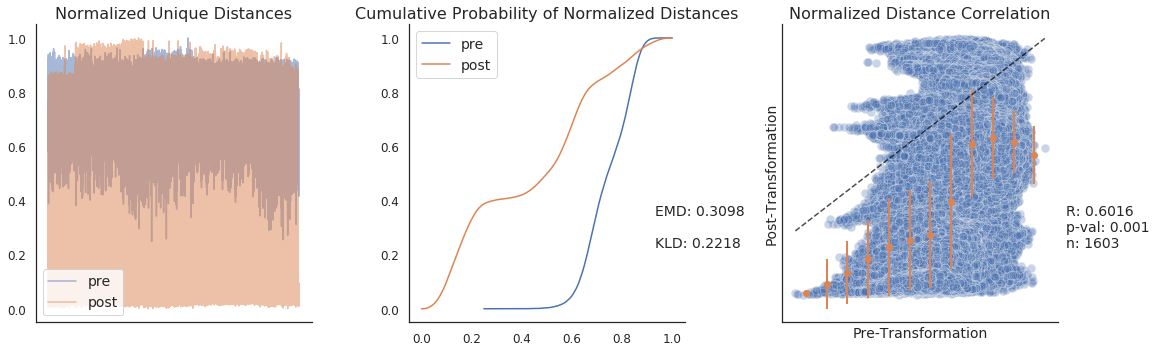

Knn Preservation: 97.3331

CPU times: user 1min 37s, sys: 1.11 s, total: 1min 38s
Wall time: 1min 36s


In [23]:
%%time
# look at SIMLR vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=retina.distance_matrix(transform='arcsinh'), post=retina_SIMLR.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_SIMLR.knn_graph(k))))

In [23]:
colon_SIMLR = DR.from_file('dev/Rmethods_out/colon_SIMLR_F.csv', name='SIMLR', labels=[None,0]) # read in low-dim space for comparison
colon_SIMLR_2D = DR.from_file('dev/Rmethods_out/colon_SIMLR_ydata.csv', name='SIMLR', labels=[None,0]) # read in 2D projection for visualization

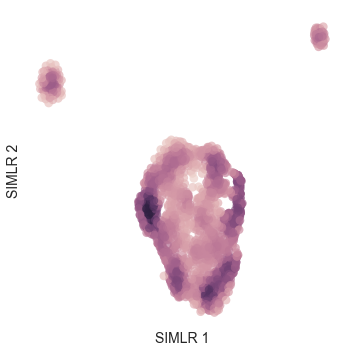

In [24]:
colon_SIMLR_2D.plot()

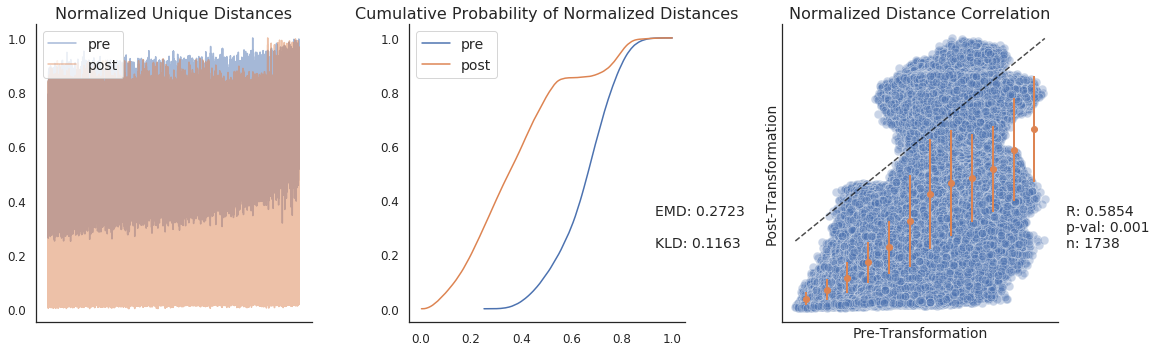

Knn Preservation: 97.8713

CPU times: user 1min 50s, sys: 14.7 s, total: 2min 5s
Wall time: 2min 4s


In [29]:
%%time
# look at SIMLR vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=colon.distance_matrix(transform='arcsinh'), post=colon_SIMLR.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_SIMLR.knn_graph(k))))

---
### ZINB-WAVE

In [29]:
retina_ZINBWAVE = DR.from_file('dev/Rmethods_out/retina_ZINB-WAVE.csv', name='ZINB-WAVE', labels=[None,0])

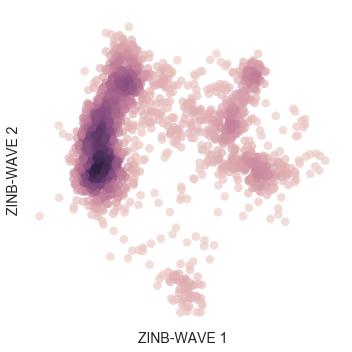

In [30]:
retina_ZINBWAVE.plot()

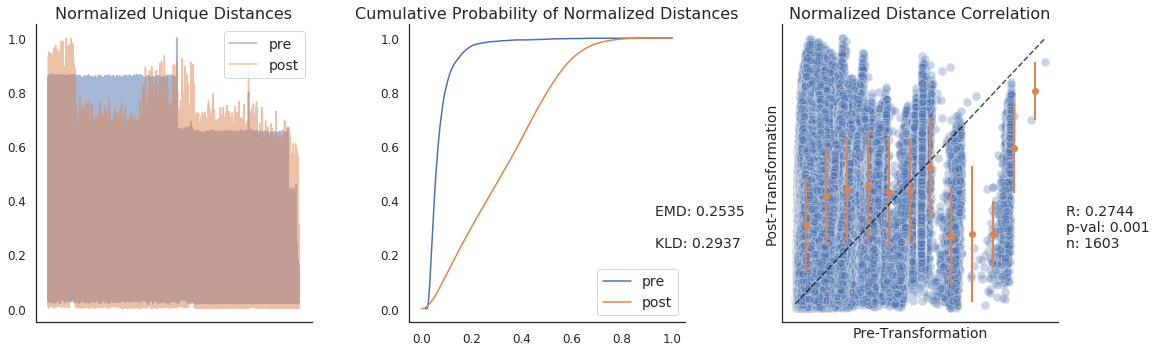

Knn Preservation: 96.7123

CPU times: user 1min 35s, sys: 1.13 s, total: 1min 36s
Wall time: 1min 35s


In [33]:
%%time
# look at ZINB-WAVE vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=retina.distance_matrix(transform=None), post=retina_ZINBWAVE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_ZINBWAVE.knn_graph(k))))

In [31]:
colon_ZINBWAVE = DR.from_file('dev/Rmethods_out/colon_ZINB-WAVE.csv', name='ZINB-WAVE', labels=[None,0])

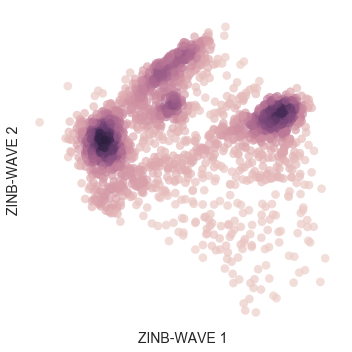

In [32]:
colon_ZINBWAVE.plot()

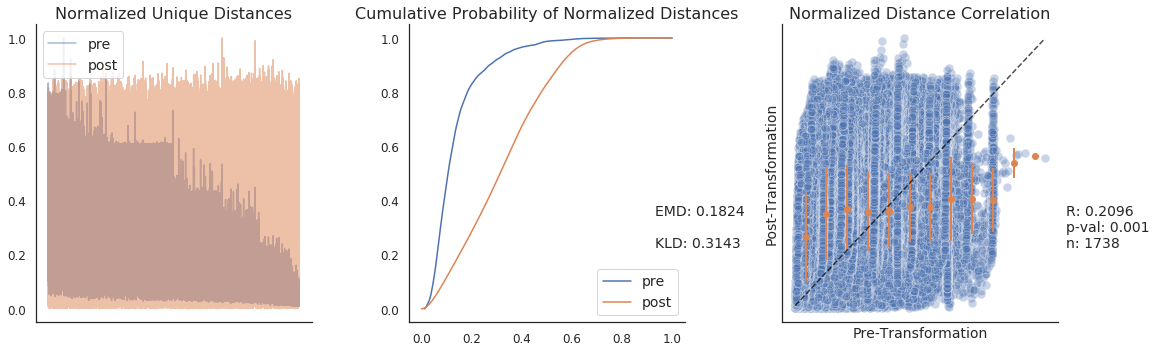

Knn Preservation: 97.1428

CPU times: user 1min 50s, sys: 14.4 s, total: 2min 5s
Wall time: 2min 3s


In [37]:
%%time
# look at ZINB-WAVE vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=colon.distance_matrix(transform=None), post=colon_ZINBWAVE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_ZINBWAVE.knn_graph(k))))

---
### GLM-PCA

In [37]:
retina_GLMPCA = DR.from_file('dev/Rmethods_out/retina_GLM-PCA.csv', name='GLM-PC', labels=[None,0])

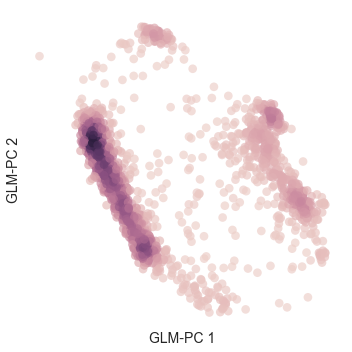

In [38]:
retina_GLMPCA.plot()

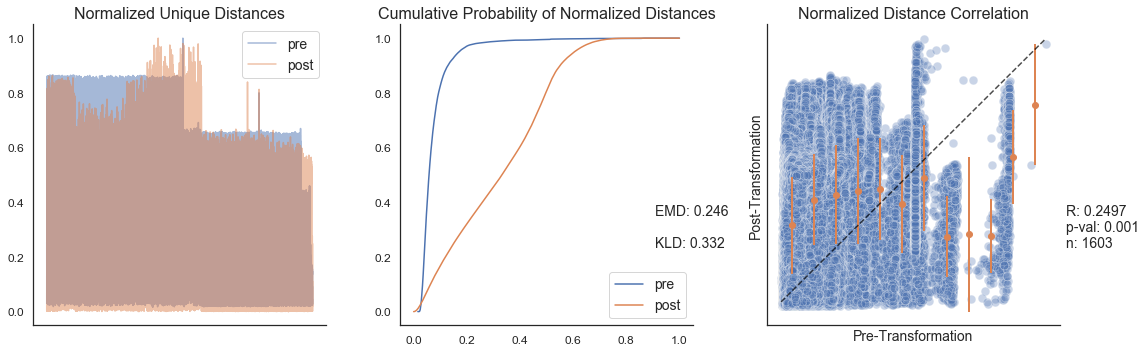

Knn Preservation: 96.6568

CPU times: user 1min 51s, sys: 13.6 s, total: 2min 5s
Wall time: 2min 15s


In [22]:
%%time
# look at GLM-PCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=retina.distance_matrix(transform=None), post=retina_GLMPCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_GLMPCA.knn_graph(k))))

In [39]:
colon_GLMPCA = DR.from_file('dev/Rmethods_out/colon_GLM-PCA.csv', name='GLM-PC', labels=[None,0])

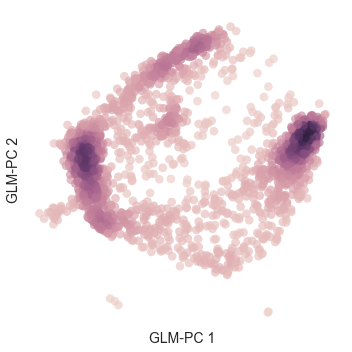

In [40]:
colon_GLMPCA.plot()

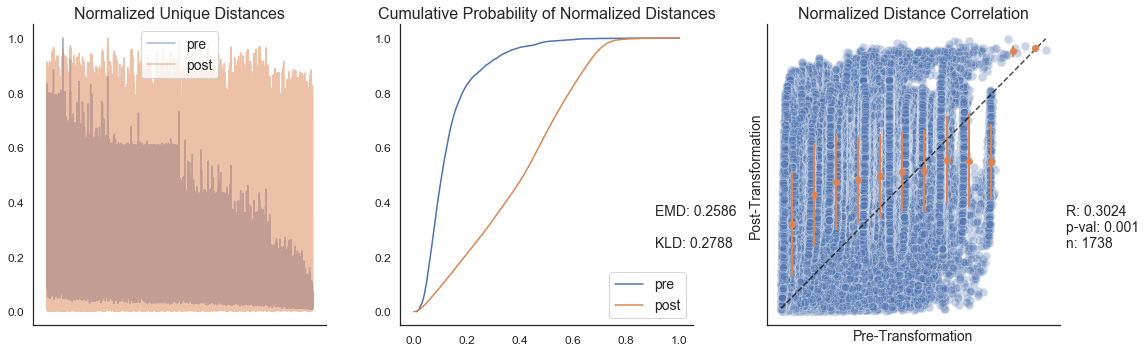

Knn Preservation: 97.1596

CPU times: user 2min 22s, sys: 14 s, total: 2min 36s
Wall time: 2min 43s


In [18]:
%%time
# look at GLM-PCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=colon.distance_matrix(transform=None), post=colon_GLMPCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_GLMPCA.knn_graph(k))))